In [47]:
from scipy.io import loadmat
import numpy as np
from scipy.optimize import minimize
from datetime import datetime
now = datetime.now

import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import os
import pickle

import json

from scipy.stats import chi2

In [48]:
SaveFitFigs = True
SaveFitData = True
dpiN = 1000
dark_plots = False
if dark_plots:
    dark='darkbg/'
    q = mpl.rc_params_from_file('matplotlibrc_dark')
else:
    dark = 'whitebg/'
    mpl.rcParams.update(mpl.rcParamsDefault)
SavePlotDir_Exp2  = '../Results/Exp2/'+dark+'FittingFigs/'
SaveDataDir_Exp2  = '../Results/Exp2/'+'Pickles/'
LoadDataDir_Exp2 = SaveDataDir_Exp2 # The other notebook stored the pickle in the same folder
if SaveFitFigs:
    if not os.path.exists(SavePlotDir_Exp2):
        os.makedirs(SavePlotDir_Exp2)
if SaveFitData:
    if not os.path.exists(SaveDataDir_Exp2):
        os.makedirs(SaveDataDir_Exp2)


In [49]:
if dark_plots:
    mpl.rcParams.update(q)
    %matplotlib inline
    mpl.rcParams.update({
                    #'legend.borderpad': 0.3,
                    #'legend.borderaxespad': 0.25,
#                     'legend.columnspacing': 0.6,
#                     'legend.handlelength': 0.7,
                    #'legend.handleheight': 0.4,
                    #'legend.handletextpad': 0.2,
#                     'legend.labelspacing': 0.45,
#                     'text.usetex': True,
                    'font.size':13,
                    })
else:
    %matplotlib inline
    # mpl.rcParams.update(mpl.rcParamsDefault)
    font = {
    #    'weight' : 'normal',
       'size'   : 15,
       'family': 'Times New Roman'}
    plt.rc('font', **font)
#     mpl.rcParams.update({'font.family':'serif'})

In [50]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from B_calc_script import TopFunctionOneExpAnyFreq

In [52]:
%autoreload 2

# Load data

In [53]:
Exp2_data_filename = LoadDataDir_Exp2+'Exp2_cut_averaged_data.pk'

In [54]:
with open(Exp2_data_filename,'rb') as file_obj:
    Exp2_data_cut = pickle.load(file_obj)

## Load parameters ##

In [55]:
with open('../Params/Exp2_dimensions_and_locations.json', 'r') as fp:
    params_dims_locs = json.load(fp)

In [56]:
params_dims_locs

{'D_wheel_sensor': 8,
 'rotor_dims': {'height': 10,
  'outer_radius': 18.9,
  'inner_radius': 15,
  'hole_radius': 2.5,
  'bar_width': 7},
 'AW_location': {'coordinate': 'cartesian',
  'location': "np.array([0.5*(rotor_dims['outer_radius']+rotor_dims['inner_radius']),0,rotor_dims['height']/2+D_wheel_sensor])"},
 'AV_location': {'coordinate': 'cartesian',
  'location': "np.array([-rotor_dims['outer_radius']-D_wheel_sensor,0,0])"}}

In [57]:
rtr_dims = params_dims_locs['rotor_dims']

In [58]:
Exp2_AW_sensor_loc =params_dims_locs['AW_location']
string_to_parse = params_dims_locs['AW_location']['location']
Exp2_AW_sensor_loc['location'] = eval(string_to_parse.replace('rotor_dims','rtr_dims').replace('D_wheel_sensor','params_dims_locs[\'D_wheel_sensor\']'))

In [59]:
Exp2_AV_sensor_loc =params_dims_locs['AV_location']
string_to_parse = params_dims_locs['AV_location']['location']
Exp2_AV_sensor_loc['location'] = eval(string_to_parse.replace('rotor_dims','rtr_dims').replace('D_wheel_sensor','params_dims_locs[\'D_wheel_sensor\']'))

In [60]:
with open('../Params/Params_3sources.pk','rb') as filehandle:
    Exp2_Opt_Params_3_sources = pickle.load(filehandle)

In [61]:
with open('../Params/Params_4sources.pk','rb') as filehandle:
    Exp2_Opt_Params_4_sources = pickle.load(filehandle)

# Calculate fitted field, chi, and plot #

In [62]:
Exp2_settings = {
    'rotor dimensions':rtr_dims,
    'sensor locations':{
        'AW':Exp2_AW_sensor_loc,
        'AV':Exp2_AV_sensor_loc},
    'bar location':0,
#     'DC shifts':[DC_shift_AVx,DC_shift_AVy,DC_shift_AWy,DC_shift_AWz]
#    'deltaB':1 #picoTesla
}

In [63]:

nu = 5

Exp2_data = {
    'theta':np.concatenate([Exp2_data_cut['theta avg'][nu]
    # ,360+Exp2_data_cut['theta avg'][nu]
    ]), 
    #theta positive for ac, negative for clockwise
    'B':{
        'AW':{
            'Z':np.concatenate([
                # Exp2_data_cut['AW']['Z avg'][nu],
                                Exp2_data_cut['AW']['Z avg'][nu]['B']]),
            'Y':np.concatenate([
                # Exp2_data_cut['AW']['Y avg'][nu],
                                Exp2_data_cut['AW']['Y avg'][nu]['B']])
        },
        'AV':{
#             'X':np.concatenate([Exp2_data_cut['AV']['Z avg'][nu]+20,Exp2_data_cut['AV']['Z avg'][nu]+20]),
            'X':np.concatenate([
                # Exp2_data_cut['AV']['X avg'][nu],
                                Exp2_data_cut['AV']['X avg'][nu]['B']]),
            'Y':np.concatenate([
                # Exp2_data_cut['AV']['Y avg'][nu],
                                Exp2_data_cut['AV']['Y avg'][nu]['B']])
#             'Y':np.concatenate([-Exp2_data_cut['AV']['Y avg'][nu]-70,-Exp2_data_cut['AV']['Y avg'][nu]-70])
        }        
    },
    'error in B':{
        'AW':{
            'Z':Exp2_data_cut['AW']['Z avg'][nu]['sigma'],
            'Y':Exp2_data_cut['AW']['Y avg'][nu]['sigma']
        },
        'AV':{
            'X':Exp2_data_cut['AV']['X avg'][nu]['sigma'],
            'Y':Exp2_data_cut['AV']['Y avg'][nu]['sigma']
        }
    }
            }

Bar location: 94.19°
DC shifts: [-34.8, 7.14, 24.43, -34.69] pT
Source 1 is located at {'coordinate': 'polar', 'location': [13.13, 9.9, 4.75]}
Source 1 has moment {'coordinate': 'polar', 'moment': [13.94, -17.85, -23.43]}
Source 2 is located at {'coordinate': 'polar', 'location': [15.01, 274.98, -4.99]}
Source 2 has moment {'coordinate': 'polar', 'moment': [10.61, -42.76, 22.08]}
Source 3 is located at {'coordinate': 'polar', 'location': [15.32, 93.28, -3.47]}
Source 3 has moment {'coordinate': 'polar', 'moment': [33.55, -28.56, -31.77]}
Total number of points are 396
Reduced chi sq = 0.0251330952


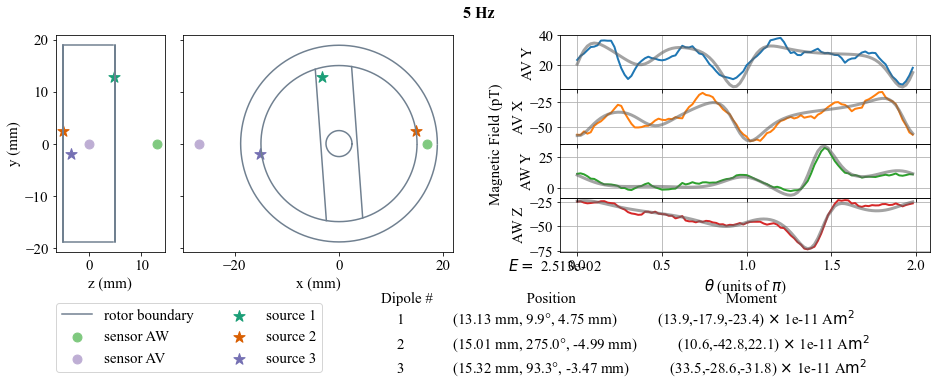

In [64]:
# nowtext = now().strftime("%Y%m%d%H%M")

nowtext = '_15font'
fitplotfilename = SavePlotDir_Exp2+'FittedData_{}Hz'.format(nu)+nowtext+'.png'
fitdatafilename = SaveDataDir_Exp2+'FittedData_{}Hz'.format(nu)+nowtext+'.pk'


Exp2_optimization_settings = {
    'print':True,
    'number of sources':3,
    'location dimensions':3,
    'moment dimensions':3,
    'location coordinate system':'polar',
    'moment coordinate system':'polar',
    'chi tolerance':10,
    'optimize DC shifts':True,
    'optimize bar location':True
}

Exp2_plot_settings = {
    'plot':True,
#     'memo':'{} Hz (AV X&Y inverted)'.format(nu),
    'memo':'{} Hz'.format(nu),
    'doubleplot':False,
    'saveplot':SaveFitFigs,
    'dpi':dpiN,
    'figname':fitplotfilename
}
Exp2_save_settings ={
    'save fit data':SaveFitData,
    'fit data filename':fitdatafilename
}

Exp2_all_settings = {
    'experiment settings':Exp2_settings,
    'data':Exp2_data,
    'optimization settings':Exp2_optimization_settings,
    'plot settings':Exp2_plot_settings,
    'save settings':Exp2_save_settings
    
}

Exp2_Opt_Params = Exp2_Opt_Params_3_sources
E_opt = TopFunctionOneExpAnyFreq(Exp2_Opt_Params,Exp2_all_settings)

In [65]:
fitplotfilename

'../Results/Exp2/whitebg/FittingFigs/FittedData_5Hz_15font.png'

# Get $\chi^2$ from Error Function ##

In [66]:
N_points = 4*len(Exp2_data_cut['theta avg'][nu])
N_params = len(Exp2_Opt_Params)

In [67]:
chi2_opt = E_opt*N_points*N_points
dof = N_points-N_params

In [68]:
sf_opt = chi2.sf(chi2_opt,dof)

In [69]:
print('Error function value is {}'.format(E_opt))
print('Number of points is ',N_points)
print("$\chi^2$ is {}".format(chi2_opt))
print('Number of parameters is ',N_params)
print('degrees of freedom is ',dof)
print("$\chi^2$/dof is {}".format(chi2_opt/dof))
print("Survival fraction is {}".format(sf_opt))

Error function value is 0.0251330952
Number of points is  396
$\chi^2$ is 3941.2714568832002
Number of parameters is  23
degrees of freedom is  373
$\chi^2$/dof is 10.566411412555496
Survival fraction is 0.0
